In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from skan import Skeleton, summarize
import skimage
import glob
from tqdm import tqdm
import pandas as pd
import math

## How it works:
### !MASK SHOULD NOT BE CROPPED - same resolution as the petri dishes images including the white strip
1. Load in mask (remove all small objects that are smaller than an average area of segmented instances)) (load_in_mask - function)
2. Determine primary roots locations (determine_primary_roots_locations - function)
3. Connect close enough starting nodes that lie in the area where seeds are supposed to be, helps with finding the highest starting point and avoiding errors with graphs analysis (connect_close_enough_starting_nodes - function)
    - Get all possible starting nodes for each plant (possible means that they lie in the assumed bounding box where the seed can lie (bounding box is derived from the template that was provided)) (get_all_possible_start_nodes_for_each_plant - function)
    - Finding the node (among all the possible nodes per plant)that is the closest to the center of the area where seeds are supposed to be (get_most_central_starting_node_for_each_plant - function)
    - loop through all the possible nodes for each plant and draw a line to connect it to the one that is closest to the center of the area where seeds are supposed to be
4. Segment primary roots (segmentation - function)
5. Segment lateral roots (colour_lateral_roots_based_on_starting_point - function) (change later)
6. Draw the segmentation on the image (last loop)

## To understand easier here are some images representing the outputs of the several functions:
- plant_bboxes -  image representing the bounding boxes for possible seeds position + the center of the box 'overlapping_roots/images_for_explanation/plants_bboxes.png'
- get_all_possible_start_nodes_for_each_plant - all starting nodes for each plant 'overlapping_roots/images_for_explanation/get_all_possible_start_nodes_for_each_plant.png'
- get_most_central_starting_node_for_each_plant - shows the starting nodes that are the closest to the center per each plant (not the best image - plants that don't have a point do not have a starting point in the bounding box for seeds 'overlapping_roots/images_for_explanation/get_most_central_starting_node_for_each_plant.png'
- determine_primary_roots_locations - primary root slice overlapping_roots/images_for_explanation/determine_primary_roots_locations.png

## Limitations that we have to fix and an image where it is visible
- Lateral root is not detected after removing small objects - overlapping_roots/overlapping_roots_segmented/000_43-18-ROOT1-2023-08-08_pvdCherry_OD001_Col0_01-Fish Eye Corrected_segmented.png
- Plant is present but not in the bounding box -> not detected - overlapping_roots/overlapping_roots_segmented/001_43-18-ROOT1-2023-08-08_pvd_OD001_Col0_02-Fish Eye Corrected_segmented.png
- Lowest node is not from this plant - overlapping_roots/overlapping_roots_segmented/015_43-18-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected_segmented.png
- The shortest path is not the primary root - overlapping_roots/overlapping_roots_segmented/019_43-19-ROOT1-2023-08-08_pvd_OD001_Col0_03-Fish Eye Corrected_segmented.png
- Primary roots is poorly detected as it's cut off in the slice image - overlapping_roots/overlapping_roots_segmented/031_43-18-ROOT1-2023-08-08_pvd_OD0001_col-0_05-Fish Eye Corrected_segmented.png (last plant) / overlapping_roots/overlapping_roots_segmented/001_43-18-ROOT1-2023-08-08_pvd_OD001_Col0_02-Fish Eye Corrected_segmented.png (3rd plant)
- Protrusions from the primary root - overlapping_roots/overlapping_roots_segmented/006_43-17-ROOT1-2023-08-08_mock_pH5_f6h1_02-Fish Eye Corrected_segmented.png

In [38]:
def remove_objects(label_count, labels, mask):
    topmost_coordinates = np.full((label_count, 2), (0, labels.shape[0]), dtype=int)
    
    new_mask = np.zeros_like(mask)

    for y in range(labels.shape[0]):
        for x in range(labels.shape[1]):
            label = labels[y, x]
            if label != 0:  # Ignore the background
                if y < topmost_coordinates[label][1]:
                    topmost_coordinates[label] = [x, y]

    for label in range(1, label_count):  # Iterate over labels instead of x
        topmost_y = topmost_coordinates[label][1]
        if topmost_y < 300:
            new_mask[labels == label] = mask[labels == label]

    return new_mask

In [39]:
def load_in_mask(path):
    
    '''
    Takes in a path to the mask, loads it in, segments it, removes all the object that are smaller than an average area of all segmented instances, transfers the image back to BGR
    
    Args:
        path: path to an image

    Returns:
        mask wihthout small noise 
    '''
    
    # read the mask
    mask = cv2.imread(path, 0)
    
    #get the labels and stats
    mask_seeding_position_label = skimage.measure.label(mask).astype('uint8')
    _, template_segmented, stats, _ = cv2.connectedComponentsWithStats(mask_seeding_position_label)
    


    
    #remove objects that are smaller than the average area
    #template_segmented = skimage.morphology.remove_small_objects(template_segmented, np.mean(stats[1:,4]))
    #template_segmented[:, 0:1000] = 0
    #template_segmented[:, 3500:] = 0
    #template_segmented = skimage.morphology.remove_small_objects(template_segmented, 150)
    
    #transfer image back to BGR
    template_segmented = (template_segmented * 255).astype(np.uint8)
    template_segmented = cv2.cvtColor(template_segmented, cv2.COLOR_GRAY2BGR)
    
    return template_segmented

In [3]:
def load_in_seedlings_template(template_path):
    '''
    
    Args:
        template_path: path to the template with seeds positions

    Returns:
        template of seeds positions that was provided
    '''
    template = cv2.imread(template_path, 0)
    return template

In [4]:
def get_plants_bboxes(path, template_path):
    '''
    Takes in the paths to the images, finds and returns the bounding boxes for each seed possible position
    
    Args:
        path: path to a mask
        template_path: path to the template with seeds positions

    Returns:
        an array with the y, y_max, x, x_max coordinates that represent the bounding boxes for each seed possible position
    '''
    
    # load in images
    mask = load_in_mask(path)
    template = load_in_seedlings_template(template_path)
    
    # uncomment this and the last line if you want to see where the midpoints are
    # template_reshaped = np.zeros_like(mask)

    # resize and prepare the template (Valerian's way, not the most robust)
    mask_seeding_position = cv2.resize(template, (mask.shape[1], mask.shape[0]))
    mask_seeding_position[mask_seeding_position < 200] = 0
    mask_seeding_position[mask_seeding_position != 0] = 255
    
    # segment the template to get the bounding boxes for each seed position
    mask_seeding_position_label = skimage.measure.label(mask_seeding_position).astype('uint8')
    _, template_segmented, stats, _ = cv2.connectedComponentsWithStats(mask_seeding_position_label)
    
    plants = []
    
    # loop through all the stats, get coordinates, transform them into y, y_max, x, x_max and append to an array
    for segment in stats[1::]:
        mid_x = (segment[0] * 2 + segment[2]) // 2
        mid_y = (segment[1] * 2 + segment[3]) // 2
        
        plants.append([segment[1],segment[1]+segment[3], segment[0], segment[0]+segment[2]])
        # template_reshaped = cv2.circle(template_reshaped,(mid_x,mid_y), 25, (255,255,255), -1)
        
    return  plants

In [5]:
def determine_starting_nodes(branch):
    '''
    Determines all the starting points in the branch
    Args:
        branch: summarize(skeleton) 

    Returns:
        an array with all the nodes-id that are starting points

    '''
    
    # get uniques src and dst nodes
    src_nodes = branch['node-id-src'].unique()
    dst_nodes = branch['node-id-dst'].unique()
    
    starting_nodes = []
    
    # loop through all src nodes if it's not in dst nodes -> append to starting nodes array
    for node in src_nodes:
        if node not in dst_nodes:
            starting_nodes.append(node)
        
    return starting_nodes

In [6]:
def get_all_possible_start_nodes_for_each_plant(path, template_path, mask = None):
    '''
    Gets all the possible nodes that can be the start of the root per each plant and returns them in an array
    Possible nodes - the highest starting points in the plants seeds bounding boxes
    
    Args:
        path: same
        template_path: same
        mask: only the connected mask is passed (connected - all starting nodes are connected to the most central node) 

    Returns:
        array of arrays with all the starting nodes belonging to the n's plant

    '''
    
    # if mask is none, it's read from the path
    # not none only in case if the mask is connected already 
    if mask is None:
        
        mask = load_in_mask(path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        
    
    
    # transform mask to the skeleton and then to the branch
    mask_skeleton = skimage.morphology.skeletonize(mask)
    mask_branch = summarize(Skeleton(mask_skeleton))
    
    # get all starting nodes and plants seeds bounding boxes
    all_starting_nodes = determine_starting_nodes(mask_branch)
    plants_bboxes = get_plants_bboxes(path, template_path)
    
    start_node_locations = [[],[],[],[],[]]

    # for each node in starting nodes check if it belongs to any of the plants seeds bounding boxes -> append to the array
    for node in all_starting_nodes:
        x = mask_branch[mask_branch['node-id-src'] == node]['image-coord-src-1'].iloc[0]
        y = mask_branch[mask_branch['node-id-src'] == node]['image-coord-src-0'].iloc[0]
        
        for i, plant in enumerate(plants_bboxes):
            y1, y2, x1, x2 = plant
            
            if x1 < x and x2> x and y1 < y and y2 > y:
                start_node_locations[i].append([x,y])


    return start_node_locations

In [7]:
def get_most_central_starting_node_for_each_plant(path, template_path, mask = None):
    '''
    Gets all the starting nodes for each plant and finds which one is the closest to the center of the bounding box for the plant and appends its coordinates, distance to the center to an array
    Args:
        path: same
        template_path: same
        mask: if none -> connected mask

    Returns:
        returns an array with the x, y, distance to the center of the bounding box for seed location of each plant
    '''
    
    # get all starting nodes
    start_node_locations = get_all_possible_start_nodes_for_each_plant(path, template_path, mask)
 
    # get all the bounding boxes where the seeds of the plants can be located
    plants_bboxes = get_plants_bboxes(path, template_path)
    starting_nodes_coordinates = []
    
    # loop through all starting nodes 
    for i, nodes in enumerate(start_node_locations):
        
        x, y = 0, 0
        
        # if there is only one starting node save its coordinates and distance to the center of the box 
        if len(nodes) == 1:
            
            x, y = nodes[0]
            y1, y2, x1, x2 = plants_bboxes[i]
            mid_point_x = (x1 + x2) // 2
            mid_point_y = (y1 + y2) // 2
            distance = np.sqrt((mid_point_x - x) ** 2 + (mid_point_y - y) ** 2)
        
        # if len != 1 get bounding box for current plant by the index (number of plants == number of arrays with the starting nodes)    
        else:
            
            # get the coordinates and midpoint coordinates of the bounding box for each plant seed postion
            y1, y2, x1, x2 = plants_bboxes[i]
            mid_point_x = (x1 + x2) // 2
            mid_point_y = (y1 + y2) // 2
            distance = 1000
            
            # for each starting point get its coordinates and distance to the center of the bounding box for the current plant
            for node in nodes:
                
                x_n, y_n = node
                distance_n = np.sqrt((mid_point_x - x_n) ** 2 + (mid_point_y - y_n) ** 2)
                
                # if the distance to center is lower than the lowest one add node to the array and replace the minimum distance with current distance (prevents adding all the starting nodes to the array)
                if distance_n < distance:
                    
                    x, y = x_n, y_n
                    distance = distance_n
                
        starting_nodes_coordinates.append((x,y, distance))
    
    return starting_nodes_coordinates

In [8]:
def connect_close_enough_starting_nodes(path, template_path):
    '''
        Loads in the mask, finds the most central starting nodes, connects them with all other starting nodes in the bounding box for each plant
    Args:
        path: same
        template_path: same

    Returns:
        returns the connected mask
    '''
    
    # load in the mask
    mask = load_in_mask(path)
    
    # don't pay attention to this ik it's messed up, for now let's leave it like this
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    
    # find all possible starting nodes for each plant
    start_node_locations = get_all_possible_start_nodes_for_each_plant(path, template_path)
    # find most central starting nodes for each plant (most central - closest to the bounding box where the seed can be located)
    central_nodes_coordinates = get_most_central_starting_node_for_each_plant(path, template_path)
    
    # loop through all the starting nodes per plant
    for i, nodes in enumerate(start_node_locations):
        
        # get the coordinates and the distance to center
        x, y, distance = central_nodes_coordinates[i]
        
        # if more than one node is present
        if len(nodes) > 1:
            
            #loop through all nodes
            for node in nodes:
                
                # get coordinates of the node
                x_n, y_n = node
                # find the distance to the center from the node
                distance_n = np.sqrt((x - x_n) ** 2 + (y - y_n) ** 2)
                # if distance from central node to the current node is lower than the distance from the center to central node -> connect the node and central node
                if distance_n < distance:
                    mask = cv2.line(mask, (x,y), (x_n, y_n), (255, 255, 255), 5)
    
    return  mask

In [9]:
def determine_primary_roots_locations(path, template_path):
    '''
        Based on the location of the bounding boxes in which the seeds are located gets a slice of the mask where the primary root is supposed to be (x min : x max, y min : bottom of the image) and returns the coordinates
    Args:
        path: same
        template_path: same 

    Returns:
        return
    '''
    
    primary_roots_locations = []
    
    # get the bounding boxes where seeds can be located for each plant 
    plants = get_plants_bboxes(path, template_path)
    
    # loop through all the bounding boxes
    for i in range(1, len(plants)+1):
        
        if i < len(plants):
            
            # get the coordinates of the previous plant bounding box 
            y1, y2, x1, x2 = plants[i-1]
            # get the coordinates of the current plant bounding box ( only right bound is needed to find the slice that is needed)
            _, _, x_right_bound, _ = plants[i]
            # append the coordinates to the array (the right bound for each plant is the starting coordinate for the next plant -> width slice = from start point of the n's plant to start of the n + 1 plant )
            primary_roots_locations.append([y1,x1,x_right_bound])
        
        # if it's the last plant the right bound is the right bound of its bounding box  
        elif i == len(plants):
            
            y1, y2, x1, x2 = plants[i-1]
            primary_roots_locations.append([y1,x1, x2])
            
    return primary_roots_locations

In [10]:
def draw_root(coordinates, image, x_offset, y_offset, colour):
    
    '''
    
    Args:
        coordinates: array of (y, x) coordinates that has to be visualised
        image: image for visualisation
        x_offset: left bound for the current plant - used to draw on the real image using the coordinates from the sliced image that focuses on a certain plant
        y_offset: top bound for the current plant -  used to draw on the real image using the coordinates from the sliced image that focuses on a certain plant
        colour: colour with which to draw

    Returns:
        returns image where the given coordinates are highlighted with the provided colour
    '''
    
    # loop through all the coordinates pairs and visualise them
    for coordinates_pair in coordinates:
        image[coordinates_pair[0] + y_offset, coordinates_pair[1] + x_offset] = colour
        
    return image

In [11]:
def prepare_data_for_segmentation(path, template_path):
    '''
         Function prepares all the data for the segmentation:
            primary_root - clear image for primary root visulisation
            skeleton - clear image for all roots visualisation
            primary_root_locations - array with the coordinates to slice image and focus on each plant primary root
            start_node_coordinates - array with the coordinates of the most central starting coordinates for each plant
            plant_bboxes - bounding boxes representing the possible locations for seed per each plant
            connected_mask - mask where all the starting nodes that are close enough to the central node for each plant are connected
    Args:
        path: same
        template_path: same
 
    Returns:

    '''
    
    # load in the mask
    mask = load_in_mask(path)
    # create empty image to draw the primary root
    primary_root = np.zeros_like(mask)
    # create empty image to draw all the roots
    skeleton = np.zeros_like(mask)
    
    # get the coordinates that are used to slice the image and focus on each primary root
    primary_roots_locations = determine_primary_roots_locations(path, template_path)
    
    # get connected mask and transform it to binary for a more accurate skeleton
    connected_mask = connect_close_enough_starting_nodes(path, template_path)
    #plt.imshow(connected_mask)
    connected_mask = cv2.cvtColor(connected_mask, cv2.COLOR_BGR2GRAY)
    connected_mask = ((connected_mask > 0) * 1).astype('uint8')
    
    # get the starting node that is the closest to the center of the bounding box which represents the possible seed location
    start_node_coordinates = get_most_central_starting_node_for_each_plant(path, template_path, mask = connected_mask)
    # get bounding boxes for each plant possible seed location
    plants_bboxes = get_plants_bboxes(path, template_path)
    
    return primary_root, skeleton, primary_roots_locations, start_node_coordinates, plants_bboxes, connected_mask

In [12]:
def calc_root_ends(simple_skeleton_branch_data, G, num_plants):
    df_bottom = pd.DataFrame(columns=simple_skeleton_branch_data.columns)
    df_top = pd.DataFrame(columns=simple_skeleton_branch_data.columns)

    for x in (np.sort(simple_skeleton_branch_data["section"].unique())):

        section_1_data = simple_skeleton_branch_data[simple_skeleton_branch_data['section'] == x]

        highest_values = section_1_data.nlargest(5, 'image-coord-dst-0')
        top_root = section_1_data.nsmallest(1, 'image-coord-dst-0')
        start_node = top_root["node-id-src"].values[0]  

        for index, row in highest_values.iterrows():
            end_node = row["node-id-dst"]
            path = nx.dijkstra_path(G, start_node, int(end_node), weight='branch-distance')
            degree_count = 0
            for x in path:
                row = simple_skeleton_branch_data[simple_skeleton_branch_data['node-id-dst'] == x]
                degree_count += abs(row["angle"].sum())
            degrees_count = degree_count / len(path)
            highest_values.at[index, "degree_count"] = degrees_count

        bottom_root = highest_values.nsmallest(1, 'degree_count')


        df_bottom = pd.concat([df_bottom, bottom_root])
        df_top = pd.concat([df_top, top_root])




    return df_bottom, df_top

In [13]:
def get_x_y(row):
    x1 = row["image-coord-src-0"]
    y1 = row["image-coord-src-1"]

    x2 = row["image-coord-dst-0"]
    y2 = row["image-coord-dst-1"]
    
    return x1, y1, x2, y2

In [14]:
def get_x_y_src(start_node_id, skeleton_branch_data):

    row = skeleton_branch_data.loc[skeleton_branch_data['node-id-src'] == start_node_id]


    x1 = row["image-coord-src-0"].iloc[0]
    y1 = row["image-coord-src-1"].iloc[0]

    return x1, y1

In [15]:
def get_x_y_dst(start_node_id, skeleton_branch_data):
    #print(skeleton_branch_data)
    #row = skeleton_branch_data.loc[skeleton_branch_data['node-id-dst'] == start_node_id]
    row = skeleton_branch_data.loc[skeleton_branch_data['node-id-src'] == start_node_id]
    print(row)
    #print(skeleton_branch_data.loc[skeleton_branch_data['node-id-src'] == start_node_id])

    x2 = row["image-coord-dst-0"].iloc[0]
    y2 = row["image-coord-dst-1"].iloc[0]

    return x2, y2

In [16]:
def calculate_angle(row):
    x1, y1, x2, y2 = get_x_y(row)
    delta_x = x2 - x1
    delta_y = y2 - y1

    angle_radians = math.atan2(delta_y, delta_x)

    angle_degrees = math.degrees(angle_radians)
    return angle_degrees

In [17]:
def calculate_angle_1(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1

    angle_radians = math.atan2(delta_y, delta_x)

    angle_degrees = math.degrees(angle_radians)
    return angle_degrees

In [18]:
def is_not_in_order(lst):
    """
    Check if a list is not in ascending order.

    This function iterates through the provided list and compares each pair of consecutive elements. 
    It returns True if it finds a pair where the earlier element is greater than the later one, indicating 
    that the list is not in ascending order. If no such pair is found throughout the list, it returns False, 
    implying the list is in ascending order.

    Parameters:
    lst (list): The list of elements to be checked. The elements should be of a type that supports comparison operators.

    Returns:
    bool: True if the list is not in ascending order, otherwise False.

    Example:
    >>> is_not_in_order([1, 2, 3, 4, 5])
    False
    >>> is_not_in_order([5, 2, 3, 4, 1])
    True
    """
    for i in range(len(lst) - 1):
        if lst[i] > lst[i + 1]:
            return True
    return False 

In [19]:
def calc_root_end(skeleton_branch_data, G ,start_node_id):



    row = skeleton_branch_data.loc[skeleton_branch_data['node-id-src'] == start_node_id]
    skeleton_id = row['skeleton-id'].values[0]
    
    #most_occurring_id = skeleton_branch_data['skeleton-id'].value_counts().idxmax()

    skeleton_branch_data = skeleton_branch_data[skeleton_branch_data['skeleton-id'] == skeleton_id].copy()


    #filtered_data = skeleton_branch_data[skeleton_branch_data['branch-type'] == 1]
    #highest_values = filtered_data.nlargest(5, 'image-coord-dst-0')

    #filtered_data = skeleton_branch_data[~skeleton_branch_data['node-id-dst'].isin(skeleton_branch_data['node-id-src'])]
    #highest_values = filtered_data.nlargest(5, 'image-coord-dst-0')


    highest_values = skeleton_branch_data.nlargest(5, 'image-coord-dst-0')

    skeleton_branch_data.loc[:, "angle"] = skeleton_branch_data.apply(calculate_angle, axis=1)
    #lowest_value = min(skeleton_branch_data["node-id-src"])
    print('plant')
    for index, row in highest_values.iterrows():
        end_node = row["node-id-dst"]
        if nx.has_path(G, start_node_id, int(end_node)):
            path = nx.dijkstra_path(G, start_node_id, int(end_node), weight='branch-distance')
        else:
            continue
        degree_count = []
        for i in range(len(path)): 
            if i == 0:
                current_row = skeleton_branch_data[skeleton_branch_data['node-id-src'] == path[i]]
            else:
                current_row = skeleton_branch_data[skeleton_branch_data['node-id-dst'] == path[i]]
            

            if current_row.empty:
                continue
            degree_count.append(current_row["angle"].values[0])


        degrees_count = np.array(degree_count)
        highest_values.at[index, "standard_deviation"] = np.std(degrees_count)

    bottom_root = highest_values.nsmallest(1, 'standard_deviation')
    checking = True
    ii = 2
    while checking:

        if bottom_root["node-id-dst"].values[0] in skeleton_branch_data["node-id-src"].values:
            bottom_root = highest_values.nlargest(ii, 'standard_deviation')
            ii += 1
        else:
            highest_image_coord_dst_0 = highest_values['image-coord-dst-0'].max()
            if bottom_root['image-coord-dst-0'].values[0] < highest_image_coord_dst_0 - 200:
                bottom_root = highest_values.nlargest(1, 'image-coord-dst-0')
                checking = False
            else:
                checking = False



    return bottom_root["node-id-dst"].values[0]


In [20]:
def are_consecutive(lst, num1, num2):
    """
    Determine if two numbers appear consecutively in a list.

    This function iterates through the list, checking if num1 is immediately followed by num2 at any position.
    If such a pair is found, the function returns True, indicating that num1 and num2 are consecutive in the list.
    If the list does not contain num1 followed directly by num2, the function returns False.

    Parameters:
    lst (list): The list of elements to be checked. The elements should be of a type that supports comparison.
    num1 (Comparable): The first number to check for consecutiveness.
    num2 (Comparable): The second number to check for consecutiveness.

    Returns:
    bool: True if num1 is immediately followed by num2 in the list, otherwise False.

    Example:
    >>> are_consecutive([1, 2, 3, 4, 5], 2, 3)
    True
    >>> are_consecutive([1, 2, 4, 5], 3, 4)
    False
    """
    
    for i in range(len(lst) - 1):
        if lst[i] == num1 and lst[i + 1] == num2:
            return True
    return False 


In [21]:
def segmentation(path, template_path):
    '''
    
    Segments root structures from an image based on a provided template.
        
        The function works through several steps:
        1. Preparing data: It first prepares the data by extracting necessary components like the root
           locations, bounding boxes, and mask of the root system.
        2. Processing each plant: For each detected plant, it processes subsets of the mask to identify
           root structures.
        3. Skeletonization: Applies skeletonization to simplify the root structures into minimal
           representations.
        4. Graph construction: Constructs a graph from the skeletonized image to represent the root
           structures.
        5. Path finding: Uses Dijkstra's algorithm to find the longest path in the graph, representing
           the primary root.
        6. Visualization: Draws the identified primary roots and updates the distances list.
        
        Parameters:
        - path (str): The file path to the image to be processed.
        - template (str): path to the template
        
        Returns:
        - primary_root (ndarray): The image with primary roots highlighted.
        - skeleton (ndarray): The skeletonized image of the root system.
        - distances (list): A list of distances along the primary root paths.
        

    '''
      
    distances = []
    # prepare needed data
    primary_root, skeleton, primary_roots_locations, start_node_coordinates, plants_bboxes, mask = prepare_data_for_segmentation(path, template_path)
    

  #  plt.imshow(mask)
    # loop through all the primary roots locations
    for i, plant in enumerate(primary_roots_locations):
        

        # slice the image to examine only primary roots (if it's the last plant the slice left bound = the end of the image)
        if i != 4:
            mask_subset = mask[plant[0]::, plant[1]:plant[2]]
        else:
            mask_subset = mask[plant[0]::, plant[1]::]
        
        #skeletonize mask and get a branch
        mask_subset_skeleton = skimage.morphology.skeletonize(mask_subset)
       # plt.imshow(mask_subset_skeleton*255)
        mask_subset_skeleton_ob = Skeleton(mask_subset_skeleton)
        mask_subset_branch = summarize(mask_subset_skeleton_ob)

        
        # get offset for the coordinates to visualise everything on the input image using the coordinates from the slice
        offset_y, _, offset_x, _ = plants_bboxes[i]
        # get the coordinates of the root start for the current plant
        start_x, start_y, _ = start_node_coordinates[i]
        
        # transform root start coordinates from the input image to the slice coordinates by substracting the offset
        start_x -= offset_x
        start_y -= offset_y
        
        # get all the end points that can be possible tips of the primary roots and reverse the id, so we go from bottom to top
        unique_last_nodes = mask_subset_branch['node-id-dst'].unique()[::-1]
        end_points = []
        for item in unique_last_nodes:
            if item not in mask_subset_branch['node-id-src'].unique():
                end_points.append(item)
        
        
        # if there is no such starting node present in the branch skip this plant 
        if len(mask_subset_branch[(mask_subset_branch['image-coord-src-0'] == start_y) & (mask_subset_branch['image-coord-src-1'] == start_x)]['node-id-src']) == 0:
            continue
        # else get the node id by the y and x coordinates
        start_node_id = mask_subset_branch[(mask_subset_branch['image-coord-src-0'] == start_y) & (mask_subset_branch['image-coord-src-1'] == start_x)]['node-id-src'].iloc[0]
        
        #tranform the branch into nx graph
        G = nx.from_pandas_edgelist(mask_subset_branch, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')


        #try:
        last_node = calc_root_end(mask_subset_branch, G, start_node_id)
        #except:
        #    plt.imshow(mask_subset_skeleton*255)

        #get the last node - assume that it's the tip of the primary root for now
       # last_node = max(G.nodes())
        
        # sort the nodes list to go from bottom to top
        un_sorted_nodes = list(G.nodes())
        sorted_nodes = sorted(un_sorted_nodes)
        
        #index for current node
        node_count = -1
        distance = 0
        last_duplicated = False
        # while distance is 0 loop through all nodes to find the first that is connected to the starting node and save the distance
        while distance == 0:
    
            node_count -= 1
            if nx.has_path(G, start_node_id, last_node):
                distance =  nx.dijkstra_path_length(G, start_node_id, last_node, weight='branch-distance')
           # else:
            #    last_node = sorted_nodes[node_count]
            
        # if the connection is found
        if distance!=0:
            
            # get the shortest path from the starting point to the end point
            path = nx.dijkstra_path(G, source=start_node_id, target=last_node, weight='branch-distance')
            # loop through the branch to visualise the root system and if the node is in the path viasualise it as a primary root
            for i in range(len(mask_subset_branch)):
                end_node = mask_subset_branch["node-id-dst"].iloc[i]
                yx = mask_subset_skeleton_ob.path_coordinates(i)

                
                                   
                skeleton = draw_root(yx, skeleton, offset_x, offset_y, (255, 255, 255))
               
                # If it's not the last node in the branch
                if i != (len(mask_subset_branch) - 1):
                    # Get current row and get the next row
                    current_row = mask_subset_branch.iloc[i]
                    next_row = mask_subset_branch.iloc[i + 1]
                    # If the current node id source and destination are the same as the next node id source and destination (Smaller portiusions)
                    if current_row["node-id-src"] == next_row["node-id-src"] and current_row["node-id-dst"] == next_row["node-id-dst"]:

                        # If the branch distance is greater than the next branch distance, we assume it's primairy root.
                        if next_row["branch-distance"] > current_row["branch-distance"]:
                            primary_root = draw_root(yx, primary_root, offset_x, offset_y, (0, 255, 0))
                            # Use last_duplicated, because the next node is lateral root.
                            last_duplicated = True
                            continue
                        else:
                            skeleton = draw_root(yx, skeleton, offset_x, offset_y, (255, 255, 255))
                            continue


                # If the last node was duplicated, we assume it's lateral root.
                if last_duplicated == True:
                    last_duplicated = False
                    skeleton = draw_root(yx, skeleton, offset_x, offset_y, (255, 255, 255))
                    continue

                # Check if the node id is in the same path while it's not part of primary root. (Bigger portiusions)
                if end_node in path:
                    consecutive = are_consecutive(path, mask_subset_branch["node-id-src"].iloc[i], mask_subset_branch["node-id-dst"].iloc[i])

                    if consecutive:
                        primary_root = draw_root(yx, primary_root, offset_x, offset_y, (0, 255, 0))
                    else:
                        skeleton = draw_root(yx, skeleton, offset_x, offset_y, (255, 255, 255))
                
        distances.append(distance)
    
        
    return primary_root, skeleton, distances

In [22]:
def colour_lateral_roots_based_on_starting_point(primary, lateral):
    '''
    
    Should be changed as this was a test of an idea if you need more explanation hmu 
    
    P.S. didn't have enough time and will to explain this one as we are going to change it completely xd

    '''
    primary_r_bin = cv2.cvtColor(primary, cv2.COLOR_RGB2GRAY)
    full_skeleton = cv2.cvtColor(lateral, cv2.COLOR_RGB2GRAY)
    
    bin = cv2.bitwise_xor(primary_r_bin, full_skeleton)
    lateral_r = ((bin > 250)*255).astype('uint8')
    
    lateral_skeleton = Skeleton(lateral_r)
    lateral_branch = summarize(lateral_skeleton)
    
    lateral_r = cv2.cvtColor(lateral_r, cv2.COLOR_GRAY2RGB)
    
    colours = [
        (255, 0, 0),
        (255, 0, 255),
        (0, 0, 255),
        (255, 255, 0),
        (0, 255, 255)
    ]
    
    segmented_roots_p1 = np.zeros_like(lateral_r)
    
    G_lat = nx.from_pandas_edgelist(lateral_branch, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')
    
    for i in range(len(lateral_branch)-1):
        start_node = lateral_branch['node-id-src'].iloc[i]
        end_node = lateral_branch['node-id-dst'].iloc[i]
        
        path = nx.dijkstra_path(G_lat, start_node, end_node)
        
        
        if len(path) == 2:
            
            colour = []
            x = lateral_branch['image-coord-src-1'].iloc[i]
            plants_subsets = [1438, 1978, 2517, 3055, 4000]
            
            for j, subset in enumerate(plants_subsets):
                
                if x < subset and colour == []:
   
                    colour = colours[j]
                    
            if not colour:
                
                colour = colours[-1]
                    
            for k in range(len(lateral_branch)):
                s_node = lateral_branch["node-id-src"].iloc[k]
                e_node = lateral_branch["node-id-dst"].iloc[k]
                yx = lateral_skeleton.path_coordinates(k)
                
                if start_node in path and e_node in path:
                    
                    segmented_roots_p1 = draw_root(yx, segmented_roots_p1, 0, 0, colour)
    
    return  segmented_roots_p1

In [23]:
def get_main_root(subset_branch, cords):
    start_x, start_y, _= cords
    subset_branch['distance'] = np.sqrt((subset_branch['image-coord-src-1'] - start_x)**2 + (subset_branch['image-coord-src-0'] - start_y)**2)
    closest_index = subset_branch['distance'].idxmin()
    closest_row = subset_branch.loc[closest_index]
    return closest_row

In [24]:
def get_simple_end(subset_branch, start_node_id):
    G = nx.from_pandas_edgelist(subset_branch, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')
    subset_branch_sorted = subset_branch.sort_values('image-coord-dst-0', ascending=False)

    for index, row in subset_branch_sorted.iterrows():
        end_node = row["node-id-dst"]
        if nx.has_path(G, start_node_id, int(end_node)):
            path = nx.dijkstra_path(G, start_node_id, int(end_node), weight='branch-distance')
            return end_node

In [25]:
def get_root_end(subset_branch, start_node_id):
    row = subset_branch.loc[subset_branch['node-id-src'] == start_node_id]
    G = nx.from_pandas_edgelist(subset_branch, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')

    start_x = row["image-coord-src-1"].iloc[0]

    lower_bound = start_x - 450
    upper_bound = start_x + 450

    filtered_df =  subset_branch[(subset_branch['image-coord-dst-1'] >= lower_bound) & (subset_branch['image-coord-dst-1'] < upper_bound)]
    last_node = get_simple_end(filtered_df, start_node_id)
    return last_node
    

    subset_branch.loc[:, "angle"] = subset_branch.apply(calculate_angle, axis=1)

    highest_values = filtered_df.nlargest(20, 'image-coord-dst-0')


    for index, row in highest_values.iterrows():
        end_node = row["node-id-dst"]
        if nx.has_path(G, start_node_id, int(end_node)):
            path = nx.dijkstra_path(G, start_node_id, int(end_node), weight='branch-distance')
        else:
            continue
        degree_count = []
        for i in range(len(path)): 
            if i == 0:
                current_row = subset_branch[subset_branch['node-id-src'] == path[i]]
            else:
                current_row = subset_branch[subset_branch['node-id-dst'] == path[i]]
            

            if current_row.empty:
                continue
            degree_count.append(current_row["angle"].values[0])

        degrees_count = np.array(degree_count)

        highest_values.at[index, "standard_deviation"] = np.std(degrees_count)



    bottom_root = highest_values.nsmallest(1, 'standard_deviation')
    checking = True
    ii = 2

    
    highest_values['Normalized_End_points'] = (highest_values['image-coord-dst-0'] - highest_values['image-coord-dst-0'].min()) / (highest_values['image-coord-dst-0'].max() - highest_values['image-coord-dst-0'].min())
    highest_values['Normalized_Std'] = (highest_values['standard_deviation'].max() - highest_values['standard_deviation']) / (highest_values['standard_deviation'].max() - highest_values['standard_deviation'].min())

    # Define weights
    weight_end_points = 0.1
    weight_std = 0.9

    # Calculate combined score
    highest_values['Combined_Score'] = weight_end_points * highest_values['Normalized_End_points'] + weight_std * highest_values['Normalized_Std']

    # Select the row with the highest combined score
    selected_row = highest_values.loc[highest_values['Combined_Score'].idxmax()]
    
    return selected_row["node-id-dst"]
    #return bottom_root["node-id-dst"].values[0], highest_values

In [27]:
def get_plants(subset_branch, path, img, im_num, subset_skeleton_ob):


    if im_num == 0:
        color = (0, 0, 255)
    elif im_num == 1:
        color = (255, 255, 0)
    elif im_num == 2:
        color = (255, 0, 0)
    elif im_num == 3:
        color = (255, 0, 255)
    elif im_num == 4:
        color = (0, 255, 255)

    subset_branch["angle"] = subset_branch.apply(calculate_angle, axis=1)

    filtered_df = filtered_df = subset_branch[subset_branch["node-id-src"].isin(path) & ~subset_branch["node-id-dst"].isin(path)]

    
    index_values = filtered_df.index.tolist()

    img2 = img.copy()

    filtered_df = filtered_df[filtered_df["angle"] > 0]

    for index in index_values:
        yx = subset_skeleton_ob.path_coordinates(index)
        img2 = draw_root(yx, img2, 0, 0, (color))
        
    sub_index = filtered_df["node-id-dst"].values


    for x in range(10):
        filtered_df = subset_branch[(subset_branch["node-id-src"].isin(sub_index) & ~subset_branch["node-id-dst"].isin(path)) | (subset_branch["node-id-dst"].isin(sub_index) & ~subset_branch["node-id-dst"].isin(path))]
        sub_index = filtered_df["node-id-dst"].values
    


        filtered_df2 = filtered_df[filtered_df["angle"] > 0]

        index_values = filtered_df2.index.tolist()

        for index in index_values:
            yx = subset_skeleton_ob.path_coordinates(index)
            img2 = draw_root(yx, img2, 0, 0, (color))


        sub_index = filtered_df["node-id-dst"].values



    return img2
    



In [49]:
im_name = "43-1-ROOT1-2023-08-08_pvd_OD001_f6h1_02-Fish Eye Corrected"
path = f"overlapping_roots_segmented_new/plates/masks/02/{im_name}"

img = cv2.imread(path + f"/{im_name}_original_padded.png")

mask_path = f"{path}/{im_name}_root_mask.png"
seeds_path = "seeding_template.tif"


primary_root, skeleton, primary_roots_locations, start_node_coordinates, plants_bboxes, mask = prepare_data_for_segmentation(mask_path, seeds_path)
subset_skeleton = skimage.morphology.skeletonize(mask)
subset_skeleton_ob = Skeleton(subset_skeleton)
subset_branch = summarize(subset_skeleton_ob)
subset_skeleton_ob_arr = np.array(subset_skeleton_ob)
total_plants = 0
img2 = img.copy()


#for x in subset_branch["skeleton-id"].unique():
#    filtered_df = subset_branch[subset_branch["skeleton-id"] == x]
#    min_value = filtered_df["image-coord-dst-1"].min()
#    max_value = filtered_df["image-coord-dst-1"].max()
#    width = max_value - min_value
    
#    plants = width // 400
    
#    if plants == 0:
 #       plants = 1
 #   total_plants += plants
#subset_skeleton_ob_arr = np.where(subset_skeleton_ob_arr != 0, 255, subset_skeleton_ob_arr)




for x in range(len(start_node_coordinates)):
    primary_root = get_main_root(subset_branch, start_node_coordinates[x])
    start_node_id = primary_root["node-id-src"]
    G = nx.from_pandas_edgelist(subset_branch, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')


    lower_bound = (x - 1) * 500
    upper_bound = x * 500
    filtered_df = subset_branch[(subset_branch['image-coord-dst-1'] >= lower_bound) & (subset_branch['image-coord-dst-1'] < upper_bound)]

    
    last_node = get_root_end(subset_branch, start_node_id)
    x_cord = int(primary_root["image-coord-src-0"])
    y = int(primary_root["image-coord-src-1"])
    cv2.circle(subset_skeleton_ob_arr, (y, x_cord), 10, (255, 255, 255), -1)
    cv2.circle(img2, (y, x_cord), 30, (0, 255, 0), 3)
    

    end_root = subset_branch.loc[subset_branch['node-id-dst'] == last_node]
    end_node_id = end_root["node-id-dst"].iloc[0]
    if len(end_root) > 1:
        max_distance_index = end_root['euclidean-distance'].idxmax()
        end_root = end_root.loc[[max_distance_index]]
    x_cord = int(end_root["image-coord-dst-0"].iloc[0])
    y = int(end_root["image-coord-dst-1"].iloc[0])
    cv2.circle(subset_skeleton_ob_arr, (y, x_cord), 10, (255, 255, 255), -1)
    cv2.circle(img2, (y, x_cord), 30, (0, 0, 0), 3)
    
    path = nx.dijkstra_path(G, start_node_id, end_node_id, weight='branch-distance')

    first_node = True
    

    #img2 = get_plants(subset_branch, path, img2, x, subset_skeleton_ob)
    
    for node in path:
        if first_node:
            row = subset_branch[subset_branch['node-id-src'] == node]
            first_node = False
        else:
            row = subset_branch[subset_branch['node-id-dst'] == node]
            
            if len(row) > 1:
                for index, sub_row in row.iterrows():
                    consecutive = are_consecutive(path, sub_row["node-id-src"], sub_row["node-id-dst"])
                    if not consecutive:
                        continue
                    else:
                        row = pd.DataFrame(sub_row).T
                        break
        
        yx = subset_skeleton_ob.path_coordinates(row.index[0])
        img2 = draw_root(yx, img2, 0, 0, (0, 0, 255))


    subset_branch["root_type"] = subset_branch.apply(lambda x: "primary" if x["node-id-dst"] in path else "lateral", axis=1)
    
    print(x)






   # primary_root = draw_root(yx, primary_root, offset_x, offset_y, (0, 255, 0))
    



0
1
2
3
4


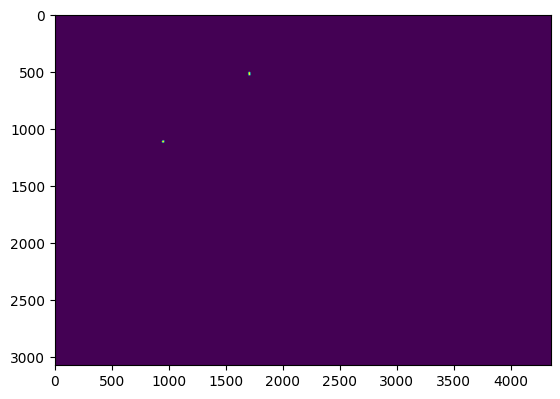

In [50]:
plt.imshow(subset_skeleton_ob_arr)

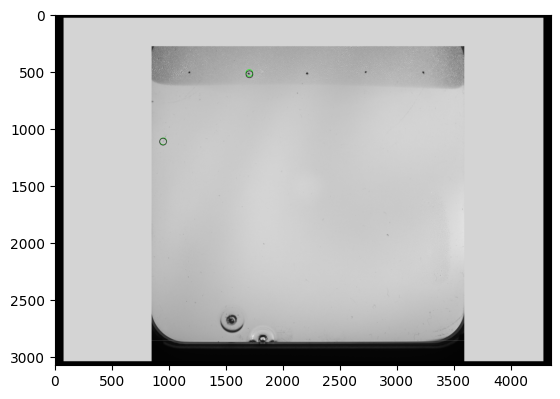

In [51]:
plt.imshow(img2)